In [185]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
% matplotlib inline

from __future__ import (division, 
                        print_function)

import os
import sys
import copy

import h5py
import numpy as np
import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel

# Matplotlib related
import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 
mpl.rcParams.update({'xtick.color': 'k'})
mpl.rcParams.update({'ytick.color': 'k'})
mpl.rcParams.update({'font.size': 20})

# Personal
import hscUtils as hUtil
import galSBP

# Cosmology
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

# SEP 
import sep

# Color map 
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
from kungpao import io
from kungpao import utils
from kungpao import detection
from kungpao import imtools
from kungpao.display import display_single

In [3]:
kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

#isophote = '/Users/song/iraf/extern/stsdas/bin.macosx/x_isophote.e'
#xttools = '/Users/song/iraf/extern/tables/bin.macosx/x_ttools.e'
isophote = '/Users/song/anaconda/pkgs/iraf-2.16.1-1/variants/common/iraf/stsci_iraf/stsdas/bin.macosx/x_isophote.e'
xttools = '/Users/song/anaconda/pkgs/iraf-2.16.1-1/variants/common/iraf/stsci_iraf/tables/bin.macosx/x_ttools.e'

### Prepare the TNG data

In [4]:
tng_dir = '/Users/song/data/massive/simulation/illustris/illustris_map/'
tng_hdf5 = os.path.join(tng_dir, 'galaxies_tng75_11.2.hdf5')

tng_file = h5py.File(tng_hdf5, 'r')

snap_a = tng_file.attrs['snap_a']
snap_z = tng_file.attrs['snap_z'] 
n_pixels = tng_file.attrs['stellar_map_np']
center_pixel = n_pixels / 2.

print(snap_a, snap_z, n_pixels, center_pixel)

0.71429 0.4 200 100.0


In [5]:
n_galaxies = len(tng_file['cat_sh_id'])
sh_idx = np.array(tng_file['cat_sh_id'])
grp_idx = np.array(tng_file['cat_grp_id'])
cat_is_primary = np.array(tng_file['cat_grp_is_primary'])
cat_sh_mstar = np.array(tng_file['cat_sh_mstar'])
cat_sh_pos_bound = np.array(tng_file['cat_sh_pos_bound'])
cat_sh_halfmrad_stars = np.array(tng_file['cat_sh_halfmrad_stars'])

# DM halo mass
cat_sh_mdm = np.array(tng_file['cat_sh_mdm'])

# DM SMBH mass
cat_sh_mbh = np.array(tng_file['cat_sh_mbh'])

print(n_galaxies)

235


In [8]:
map_stars_insitu = np.array(tng_file['map_stars_insitu'])
map_stars_exsitu = np.array(tng_file['map_stars_exsitu'])
map_stars = map_stars_exsitu + map_stars_insitu

map_size = tng_file.attrs['stellar_map_size']
n_pixels = tng_file.attrs['stellar_map_np']

pixel_scale = 2 * (map_size / n_pixels)
tng_file.close()

print(map_size, n_pixels, pixel_scale)

500.0 200 5.0


In [203]:
def tng_get_mass_maps(tng_hdf5, proj=1):
    """Summarize the stellar mass maps and save them."""
    tng_file = h5py.File(tng_hdf5, 'r')
    n_galaxies = len(tng_file['cat_sh_id'])
    map_stars_insitu = np.array(tng_file['map_stars_insitu'])
    map_stars_exsitu = np.array(tng_file['map_stars_exsitu'])
    map_stars = map_stars_exsitu + map_stars_insitu

    map_size = tng_file.attrs['stellar_map_size']
    n_pixels = tng_file.attrs['stellar_map_np']

    pixel_scale = 2 * (map_size / n_pixels)
    tng_file.close()

    tng_maps = []
    
    for gal_n in range(n_galaxies):
        img_ins = map_stars_insitu[gal_n, 0, proj] * (pixel_scale ** 2)
        img_exs = map_stars_exsitu[gal_n, 0, proj] * (pixel_scale ** 2)
        img_cen = map_stars[gal_n, 0, proj] * (pixel_scale ** 2)
        img_sat = map_stars[gal_n, 1, proj] * (pixel_scale ** 2)
        img_icl = map_stars[gal_n, 2, proj] * (pixel_scale ** 2)
        img_all = img_cen + img_sat + img_icl

        prefix = 'tng_%s' % str(gal_n).strip()

        # Central only 
        cen_fits = os.path.join(tng_dir, prefix + "_cen_%d.fits" % proj)
        _ = io.save_to_fits(img_cen, cen_fits)

        # In-situ stars
        ins_fits = os.path.join(tng_dir, prefix + "_ins_%d.fits" % proj)
        _ = io.save_to_fits(img_ins, ins_fits)

        # Ex-situ stars
        exs_fits = os.path.join(tng_dir, prefix + "_exs_%d.fits" % proj)
        _ = io.save_to_fits(img_exs, exs_fits)

        # Everything
        all_fits = os.path.join(tng_dir, prefix + "_all_%d.fits" % proj)
        _ = io.save_to_fits(img_all, all_fits)

        tng_maps.append(np.stack([img_cen, img_ins, img_exs, 
                                  img_all, img_sat, img_icl]))
    
    return tng_maps

In [204]:
tng_maps_0 = tng_get_mass_maps(tng_hdf5, proj=0)
tng_maps_1 = tng_get_mass_maps(tng_hdf5, proj=1)
tng_maps_2 = tng_get_mass_maps(tng_hdf5, proj=2)

In [30]:
np.save(os.path.join(tng_dir, 'tng_maps_0.npy'), np.asarray(tng_maps_0))
np.save(os.path.join(tng_dir, 'tng_maps_1.npy'), np.asarray(tng_maps_1))
np.save(os.path.join(tng_dir, 'tng_maps_2.npy'), np.asarray(tng_maps_2))

### Aperture photometry

In [155]:
def tng_aperture_photometry(img, img_cen_x=100, img_cen_y=100, scale=5.0):
    """Aperture photometry information for TNG galaxy."""
    bkg = sep.Background(img, bw=10, bh=10, fw=5, fh=5)
    img_sub = img - bkg
    objects = sep.extract(img_sub, 20.0, filter_kernel=kernel3)

    # Find the object at the center
    index = np.argmin(np.sqrt((objects['x'] - img_cen_x) ** 2.0 + 
                              (objects['y'] - img_cen_y) ** 2.0))

    # Get the naive ba, theta, xcen, ycen
    ba = objects[index]['b'] / objects[index]['a']
    theta = objects[index]['theta']
    xcen, ycen = objects[index]['x'], objects[index]['y']
    
    # Mass within different apertures
    rad = np.asarray([10.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0, 200.0])
    maper = sep.sum_ellipse(img, xcen, ycen, rad / scale, rad /scale * ba, theta, 1.0, 
                            bkgann=None, subpix=11)[0]

    aper_results = {'x': xcen, 'y': ycen, 'ba': ba, 'pa': theta,
                    'rad': rad, 'maper': np.log10(maper)}
    
    return aper_results

In [156]:
tng_aperture_photometry(tng_maps_0[0][0])

{'ba': 0.7025570951952638,
 'maper': array([11.56839838, 11.90730591, 12.04823372, 12.12328879, 12.16899479,
        12.26766546, 12.31362292, 12.34251175]),
 'pa': -1.0300451517105103,
 'rad': array([ 10.,  20.,  30.,  40.,  50., 100., 150., 200.]),
 'x': 99.31308438695395,
 'y': 98.54254944615698}

In [159]:
# Aperture photometry results for central galaxies 
tng_0_cen_aper = [tng_aperture_photometry(gal[0]) for gal in tng_maps_0]
tng_1_cen_aper = [tng_aperture_photometry(gal[0]) for gal in tng_maps_1]
tng_2_cen_aper = [tng_aperture_photometry(gal[0]) for gal in tng_maps_2]

In [160]:
# Aperture photometry results for in-situ components
tng_0_ins_aper = [tng_aperture_photometry(gal[1]) for gal in tng_maps_0]
tng_1_ins_aper = [tng_aperture_photometry(gal[1]) for gal in tng_maps_1]
tng_2_ins_aper = [tng_aperture_photometry(gal[1]) for gal in tng_maps_2]

In [161]:
# Aperture photometry results for ex-situ components
tng_0_exs_aper = [tng_aperture_photometry(gal[2]) for gal in tng_maps_0]
tng_1_exs_aper = [tng_aperture_photometry(gal[2]) for gal in tng_maps_1]
tng_2_exs_aper = [tng_aperture_photometry(gal[2]) for gal in tng_maps_2]

In [163]:
np.save(os.path.join(tng_dir, 'tng_0_cen_aper.npy'), tng_0_cen_aper)
np.save(os.path.join(tng_dir, 'tng_1_cen_aper.npy'), tng_1_cen_aper)
np.save(os.path.join(tng_dir, 'tng_2_cen_aper.npy'), tng_2_cen_aper)

np.save(os.path.join(tng_dir, 'tng_0_ins_aper.npy'), tng_0_ins_aper)
np.save(os.path.join(tng_dir, 'tng_1_ins_aper.npy'), tng_1_ins_aper)
np.save(os.path.join(tng_dir, 'tng_2_ins_aper.npy'), tng_2_ins_aper)

np.save(os.path.join(tng_dir, 'tng_0_exs_aper.npy'), tng_0_exs_aper)
np.save(os.path.join(tng_dir, 'tng_1_exs_aper.npy'), tng_1_exs_aper)
np.save(os.path.join(tng_dir, 'tng_2_exs_aper.npy'), tng_2_exs_aper)

In [173]:
tng_logms_cat = np.log10(cat_sh_mstar)

#### Axis ratio

In [168]:
tng_0_ins_ba = np.asarray([aper['ba'] for aper in tng_0_ins_aper])
tng_0_exs_ba = np.asarray([aper['ba'] for aper in tng_0_exs_aper])

tng_1_ins_ba = np.asarray([aper['ba'] for aper in tng_1_ins_aper])
tng_1_exs_ba = np.asarray([aper['ba'] for aper in tng_1_exs_aper])

tng_2_ins_ba = np.asarray([aper['ba'] for aper in tng_2_ins_aper])
tng_2_exs_ba = np.asarray([aper['ba'] for aper in tng_2_exs_aper])

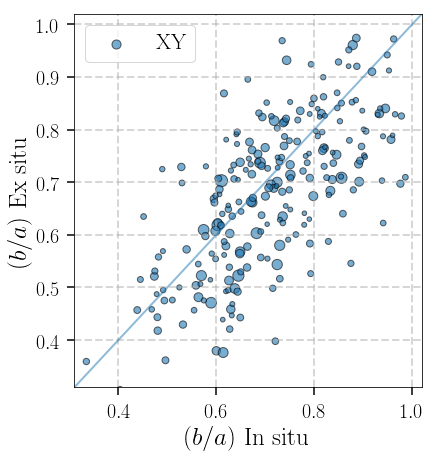

In [189]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2.0, alpha=0.5, linestyle='--')

ax1.scatter(tng_0_ins_ba, tng_0_exs_ba, s=(tng_logms_cat - 11.0) * 100.0, 
            alpha=0.6, edgecolor='k', label=r'$\mathrm{XY}$')
#ax1.scatter(tng_1_ins_ba, tng_1_exs_ba, s=30, alpha=0.7, label=r'$\mathrm{YZ}$')
#ax1.scatter(tng_2_ins_ba, tng_2_exs_ba, s=30, alpha=0.7, label=r'$\mathrm{XZ}$')

ax1.plot([0.0, 1.5], [0.0, 1.5], linewidth=2.0, alpha=0.5)

ax1.legend(fontsize=22)

ax1.set_xlabel('$(b/a)\ \mathrm{In\ situ}$', size=25)
ax1.set_ylabel('$(b/a)\ \mathrm{Ex\ situ}$', size=25)

_ = ax1.set_xlim(0.31, 1.02)
_ = ax1.set_ylim(0.31, 1.02)

Text(0,0.5,'$(b/a)_{\\mathrm{In\\ situ}} - (b/a)_{\\mathrm{Ex\\ situ}}$')

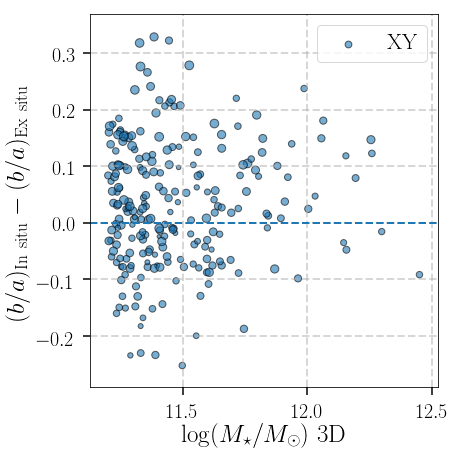

In [192]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2.0, alpha=0.5, linestyle='--')

ax1.scatter(tng_logms_cat, tng_0_ins_ba - tng_0_exs_ba, 
            s=(tng_0_ins_ba - 0.2) * 100, 
            alpha=0.6, edgecolor='k', label=r'$\mathrm{XY}$')
#ax1.scatter(tng_1_ins_ba, tng_1_exs_ba, s=30, alpha=0.7, label=r'$\mathrm{YZ}$')
#ax1.scatter(tng_2_ins_ba, tng_2_exs_ba, s=30, alpha=0.7, label=r'$\mathrm{XZ}$')

ax1.axhline(0.0, linewidth=2.0, linestyle='--')

ax1.legend(fontsize=22)

ax1.set_xlabel('$\log (M_{\star}/M_{\odot})\ \mathrm{3D}$', size=25)
ax1.set_ylabel('$(b/a)_{\mathrm{In\ situ}} - (b/a)_{\mathrm{Ex\ situ}}$', size=25)

#_ = ax1.set_xlim(0.31, 1.02)
#_ = ax1.set_ylim(0.31, 1.02)

#### Position angle

In [195]:
tng_0_ins_pa = np.asarray([aper['pa'] * 180.0 / np.pi for aper in tng_0_ins_aper])
tng_0_exs_pa = np.asarray([aper['pa'] * 180.0 / np.pi for aper in tng_0_exs_aper])

tng_1_ins_pa = np.asarray([aper['pa'] for aper in tng_1_ins_aper])
tng_1_exs_pa = np.asarray([aper['pa'] for aper in tng_1_exs_aper])

tng_2_ins_pa = np.asarray([aper['pa'] for aper in tng_2_ins_aper])
tng_2_exs_pa = np.asarray([aper['pa'] for aper in tng_2_exs_aper])

Text(0,0.5,'$\\mathrm{PA}\\ \\mathrm{Ex\\ situ}$')

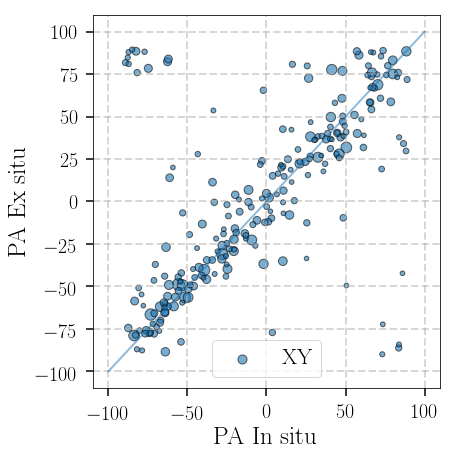

In [197]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2.0, alpha=0.5, linestyle='--')

ax1.scatter(tng_0_ins_pa, tng_0_exs_pa, s=(tng_logms_cat - 11.0) * 100.0, 
            alpha=0.6, edgecolor='k', label=r'$\mathrm{XY}$')
#ax1.scatter(tng_1_ins_pa, tng_1_exs_pa, s=30, alpha=0.7, label=r'$\mathrm{YZ}$')
#ax1.scatter(tng_2_ins_pa, tng_2_exs_pa, s=30, alpha=0.7, label=r'$\mathrm{XZ}$')

ax1.plot([-100, 100], [-100, 100], linewidth=2.0, alpha=0.5)

ax1.legend(fontsize=22)

ax1.set_xlabel('$\mathrm{PA}\ \mathrm{In\ situ}$', size=25)
ax1.set_ylabel('$\mathrm{PA}\ \mathrm{Ex\ situ}$', size=25)

# _ = ax1.set_xlim(0.31, 1.02)
# _ = ax1.set_ylim(0.31, 1.02)

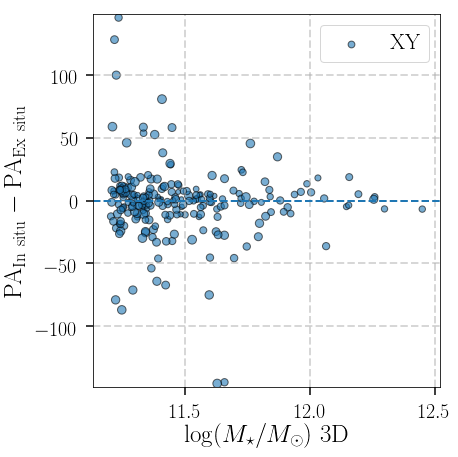

In [202]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=2.0, alpha=0.5, linestyle='--')

ax1.scatter(tng_logms_cat, tng_0_ins_pa - tng_0_exs_pa, 
            s=(tng_0_ins_ba - 0.2) * 100, 
            alpha=0.6, edgecolor='k', label=r'$\mathrm{XY}$')
#ax1.scatter(tng_1_ins_pa, tng_1_exs_pa, s=30, alpha=0.7, label=r'$\mathrm{YZ}$')
#ax1.scatter(tng_2_ins_pa, tng_2_exs_pa, s=30, alpha=0.7, label=r'$\mathrm{XZ}$')

ax1.axhline(0.0, linewidth=2.0, linestyle='--')

ax1.legend(fontsize=22)

ax1.set_xlabel('$\log (M_{\star}/M_{\odot})\ \mathrm{3D}$', size=25)
ax1.set_ylabel('$\mathrm{PA}_{\mathrm{In\ situ}} - \mathrm{PA}_{\mathrm{Ex\ situ}}$', size=25)

#_ = ax1.set_xlim(0.31, 1.02)
_ = ax1.set_ylim(-149, 149)